# Return Prediction With Linear Regression

## Imports and Settings

In [4]:
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

from time import time
from pathlib import Path
import pandas as pd
import numpy as np
from scipy.stats import spearmanr

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.pipeline import Pipeline

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

In [5]:
sns.set_style('darkgrid')
idx = pd.IndexSlice

In [6]:
YEAR = 252

## Load Data

In [7]:
with pd.HDFStore('data.h5') as store:
    data = (store['model_data']
            .dropna()
            .drop(['open', 'close', 'low', 'high'], axis=1))

data.index.names = ['symbol', 'date']
data = data.drop([c for c in data.columns if 'lag' in c], axis=1)

### Select Investment Universe

In [8]:
data = data[data.dollar_vol_rank<100]

In [9]:
data.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 1189975 entries, ('A', Timestamp('2000-05-19 00:00:00')) to ('ZTS', Timestamp('2022-02-02 00:00:00'))
Data columns (total 24 columns):
 #   Column           Non-Null Count    Dtype  
---  ------           --------------    -----  
 0   adjusted_close   1189975 non-null  float64
 1   volume           1189975 non-null  float64
 2   dollar_vol       1189975 non-null  float64
 3   dollar_vol_1m    1189975 non-null  float64
 4   dollar_vol_rank  1189975 non-null  float64
 5   rsi              1189975 non-null  float64
 6   bb_high          1189975 non-null  float64
 7   bb_low           1189975 non-null  float64
 8   atr              1189975 non-null  float64
 9   macd             1189975 non-null  float64
 10  return_1d        1189975 non-null  float64
 11  return_5d        1189975 non-null  float64
 12  return_10d       1189975 non-null  float64
 13  return_21d       1189975 non-null  float64
 14  return_42d       1189975 non-null  float64

In [11]:
data.columns

Index(['adjusted_close', 'volume', 'dollar_vol', 'dollar_vol_1m',
       'dollar_vol_rank', 'rsi', 'bb_high', 'bb_low', 'atr', 'macd',
       'return_1d', 'return_5d', 'return_10d', 'return_21d', 'return_42d',
       'return_63d', 'target_1d', 'target_5d', 'target_10d', 'target_21d',
       'Sector', 'year', 'month', 'sector_factor'],
      dtype='object')

### Create Model Data

In [12]:
y = data.filter(like='target')
X = data.drop(y.columns, axis=1)
X = X.drop(['dollar_vol', 'dollar_vol_rank', 'volume', 'Sector'], axis=1)

## MultipleTimeSeriesCV

In [13]:
class MultipleTimeSeriesCV:
    """Generates tuples of train_idx, test_idx pairs
    Assumes the MultiIndex contains levels 'symbol' and 'date'
    purges overlapping outcomes"""

    def __init__(self,
                 n_splits=3,
                 train_period_length=126,
                 test_period_length=21,
                 lookahead=None,
                 shuffle=False):
        self.n_splits = n_splits
        self.lookahead = lookahead
        self.test_length = test_period_length
        self.train_length = train_period_length
        self.shuffle = shuffle

    def split(self, X, y=None, groups=None):
        unique_dates = X.index.get_level_values('date').unique()
        days = sorted(unique_dates, reverse=True)

        split_idx = []
        for i in range(self.n_splits):
            test_end_idx = i * self.test_length
            test_start_idx = test_end_idx + self.test_length
            train_end_idx = test_start_idx + + self.lookahead - 1
            train_start_idx = train_end_idx + self.train_length + self.lookahead - 1
            split_idx.append([train_start_idx, train_end_idx,
                              test_start_idx, test_end_idx])

        dates = X.reset_index()[['date']]
        for train_start, train_end, test_start, test_end in split_idx:
            train_idx = dates[(dates.date > days[train_start])
                              & (dates.date <= days[train_end])].index
            test_idx = dates[(dates.date > days[test_start])
                             & (dates.date <= days[test_end])].index
            if self.shuffle:
                np.random.shuffle(list(train_idx))
            yield train_idx, test_idx

    def get_n_splits(self, X, y, groups=None):
        return self.n_splits

In [14]:
train_period_length = 63
test_period_length = 10
n_splits = int(3 * YEAR/test_period_length)
lookahead =1 

cv = MultipleTimeSeriesCV(n_splits=n_splits,
                          test_period_length=test_period_length,
                          lookahead=lookahead,
                          train_period_length=train_period_length)

In [15]:
i = 0
for train_idx, test_idx in cv.split(X=data):
    train = data.iloc[train_idx]
    train_dates = train.index.get_level_values('date')
    test = data.iloc[test_idx]
    test_dates = test.index.get_level_values('date')
    df = train.reset_index().append(test.reset_index())
    n = len(df)
    assert n== len(df.drop_duplicates())
    print(train.groupby(level='symbol').size().value_counts().index[0],
          train_dates.min().date(), train_dates.max().date(),
          test.groupby(level='symbol').size().value_counts().index[0],
          test_dates.min().date(), test_dates.max().date())
    i += 1
    if i == 10:
        break

63 2022-10-07 2023-01-06 10 2023-01-09 2023-01-23
63 2022-09-23 2022-12-21 10 2022-12-22 2023-01-06
63 2022-09-09 2022-12-07 10 2022-12-08 2022-12-21
63 2022-08-25 2022-11-22 10 2022-11-23 2022-12-07
63 2022-08-11 2022-11-08 10 2022-11-09 2022-11-22
63 2022-07-28 2022-10-25 10 2022-10-26 2022-11-08
63 2022-07-14 2022-10-11 10 2022-10-12 2022-10-25
63 2022-06-29 2022-09-27 10 2022-09-28 2022-10-11
63 2022-06-14 2022-09-13 10 2022-09-14 2022-09-27
63 2022-05-31 2022-08-29 10 2022-08-30 2022-09-13


## Visualization helper functions

### Prediction vs Actual Scatter Plot

In [16]:
def plot_preds_scatter(df, ticker=None):
    if ticker is not None:
        idx = pd.IndexSlice
        df = df.loc[idx[ticker, :], :]
    j = sns.jointplot(x='predicted', y='actuals',
                      robust=True, ci=None,
                      line_kws={'lw': 1, 'color': 'k'},
                      scatter_kws={'s': 1},
                      data=df,
                      kind='reg')
    j.ax_joint.yaxis.set_major_formatter(
        FuncFormatter(lambda y, _: '{:.1%}'.format(y)))
    j.ax_joint.xaxis.set_major_formatter(
        FuncFormatter(lambda x, _: '{:.1%}'.format(x)))
    j.ax_joint.set_xlabel('Predicted')
    j.ax_joint.set_ylabel('Actuals')

### Daily IC Distribution

In [17]:
def plot_ic_distribution(df, ax=None):
    if ax is not None:
        sns.distplot(df.ic, ax=ax)
    else:
        ax = sns.distplot(df.ic)
    mean, median = df.ic.mean(), df.ic.median()
    ax.axvline(0, lw=1, ls='--', c='k')
    ax.text(x=.05, y=.9,
            s=f'Mean: {mean:8.2f}\nMedian: {median:5.2f}',
            horizontalalignment='left',
            verticalalignment='center',
            transform=ax.transAxes)
    ax.set_xlabel('Information Coefficient')
    sns.despine()
    plt.tight_layout()

### Rolling Daily IC

In [18]:
def plot_rolling_ic(df):
    fig, axes = plt.subplots(nrows=2, sharex=True, figsize=(14, 8))
    rolling_result = df.sort_index().rolling(21).mean().dropna()
    mean_ic = df.ic.mean()
    rolling_result.ic.plot(ax=axes[0],
                           title=f'Information Coefficient (Mean: {mean_ic:.2f})',
                           lw=1)
    axes[0].axhline(0, lw=.5, ls='-', color='k')
    axes[0].axhline(mean_ic, lw=1, ls='--', color='k')

    mean_rmse = df.rmse.mean()
    rolling_result.rmse.plot(ax=axes[1],
                             title=f'Root Mean Squared Error (Mean: {mean_rmse:.2%})',
                             lw=1,
                             ylim=(0, df.rmse.max()))
    axes[1].axhline(df.rmse.mean(), lw=1, ls='--', color='k')
    sns.despine()
    plt.tight_layout()

## Linear Regression With Sklearn

### Set up cross-validation

In [19]:
train_period_length = 63
test_period_length = 10
n_splits = int(3 * YEAR / test_period_length)
lookahead = 1

cv = MultipleTimeSeriesCV(n_splits=n_splits,
                          test_period_length=test_period_length,
                          lookahead=lookahead,
                          train_period_length=train_period_length)

### Run cross-validation with LinearRegression 

In [20]:
%%time
target = f'target_{lookahead}d'
lr_predictions, lr_scores = [], []
lr = LinearRegression()
for i, (train_idx, test_idx) in enumerate(cv.split(X), 1):
    X_train, y_train, = X.iloc[train_idx], y[target].iloc[train_idx]
    X_test, y_test = X.iloc[test_idx], y[target].iloc[test_idx]
    lr.fit(X=X_train, y=y_train)
    y_pred = lr.predict(X_test)

    preds = y_test.to_frame('actuals').assign(predicted=y_pred)
    preds_by_day = preds.groupby(level='date')
    scores = pd.concat([preds_by_day.apply(lambda x: spearmanr(x.predicted,
                                                               x.actuals)[0] * 100)
                        .to_frame('ic'),
                        preds_by_day.apply(lambda x: np.sqrt(mean_squared_error(y_pred=x.predicted,
                                                                                y_true=x.actuals)))
                        .to_frame('rmse')], axis=1)

    lr_scores.append(scores)
    lr_predictions.append(preds)

lr_scores = pd.concat(lr_scores)
lr_predictions = pd.concat(lr_predictions)

CPU times: user 15.1 s, sys: 524 ms, total: 15.6 s
Wall time: 2.77 s


### Store Results

In [21]:
lr_scores.to_hdf('data.h5', 'lr/scores')
lr_predictions.to_hdf('data.h5', 'lr/predictions')

In [22]:
lr_scores = pd.read_hdf('data.h5', 'lr/scores')
lr_predictions = pd.read_hdf('data.h5', 'lr/predictions')

### Evaluate Results

In [23]:
lr_r, lr_p = spearmanr(lr_predictions.actuals, lr_predictions.predicted)
print(f'Information Coefficient (overall): {lr_r:.3%} (p-value: {lr_p:.4%})')

Information Coefficient (overall): -3.361% (p-value: 0.0000%)


#### Prediction vs Actuals Scatter

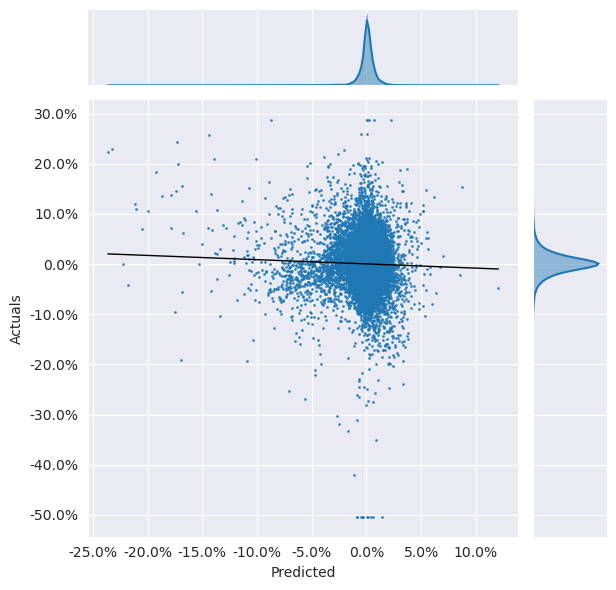

In [25]:
plot_preds_scatter(lr_predictions)

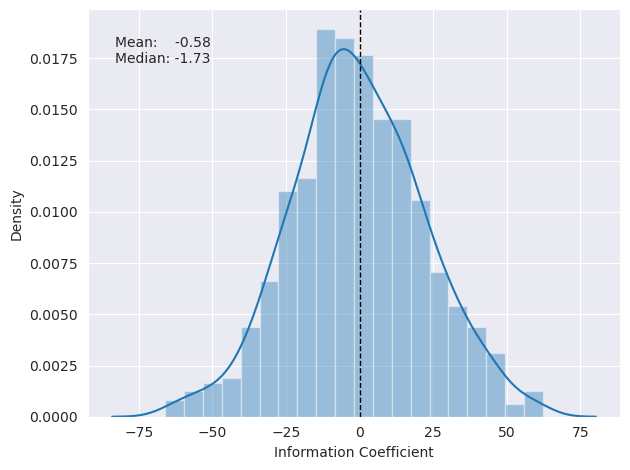

In [26]:
plot_ic_distribution(lr_scores)

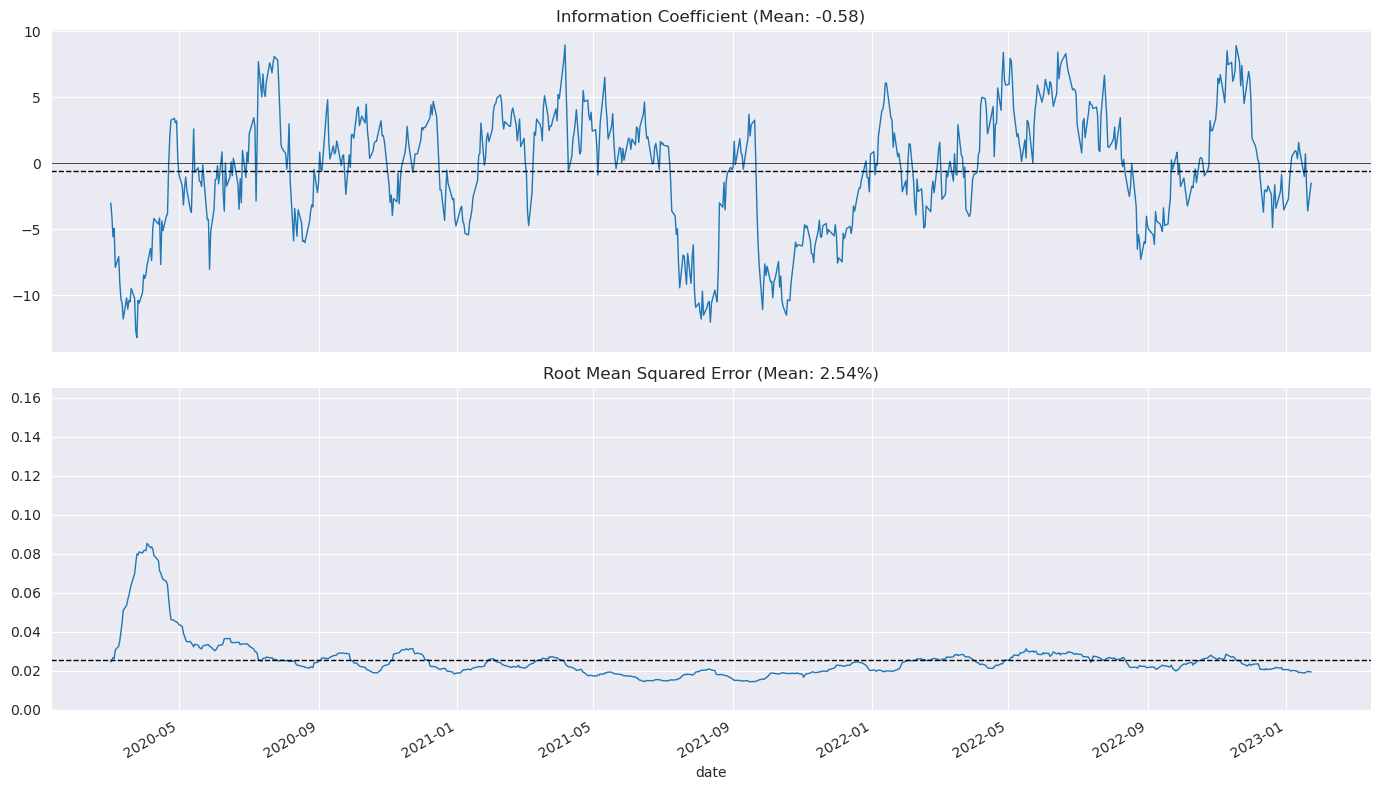

In [27]:
plot_rolling_ic(lr_scores)

## Ridge Regression

### Define cross-validation parameters

In [28]:
ridge_alphas = np.logspace(-4, 4, 9)
ridge_alphas = sorted(list(ridge_alphas) + list(ridge_alphas * 5))

In [29]:
n_splits = int(3 * YEAR/test_period_length)
train_period_length = 63
test_period_length = 10
lookahead = 1

cv = MultipleTimeSeriesCV(n_splits=n_splits,
                          test_period_length=test_period_length,
                          lookahead=lookahead,
                          train_period_length=train_period_length)

### Run Cross Validation

In [30]:
target = f'target_{lookahead}d'

X = X.drop([c for c in X.columns if 'year' in c], axis=1)

In [31]:
%%time
ridge_coeffs, ridge_scores, ridge_predictions = {}, [], []

for alpha in ridge_alphas:
    print(alpha, end=' ', flush=True)
    start = time()
    model = Ridge(alpha=alpha,
                  fit_intercept=False,
                  random_state=42)

    pipe = Pipeline([
        ('scaler', StandardScaler()),
        ('model', model)])

    coeffs = []
    for i, (train_idx, test_idx) in enumerate(cv.split(X), 1):
        X_train, y_train, = X.iloc[train_idx], y[target].iloc[train_idx]
        X_test, y_test = X.iloc[test_idx], y[target].iloc[test_idx]

        pipe.fit(X=X_train, y=y_train)
        y_pred = pipe.predict(X_test)

        preds = y_test.to_frame('actuals').assign(predicted=y_pred)
        preds_by_day = preds.groupby(level='date')
        scores = pd.concat([preds_by_day.apply(lambda x: spearmanr(x.predicted,
                                                                   x.actuals)[0] * 100)
                            .to_frame('ic'),
                            preds_by_day.apply(lambda x: np.sqrt(mean_squared_error(y_pred=x.predicted,
                                                                                    y_true=x.actuals)))
                            .to_frame('rmse')], axis=1)

        ridge_scores.append(scores.assign(alpha=alpha))
        ridge_predictions.append(preds.assign(alpha=alpha))

        coeffs.append(pipe.named_steps['model'].coef_)
    ridge_coeffs[alpha] = np.mean(coeffs, axis=0)

print('\n')

0.0001 0.0005 0.001 0.005 0.01 0.05 0.1 0.5 1.0 5.0 10.0 50.0 100.0 500.0 1000.0 5000.0 10000.0 50000.0 

CPU times: user 5min 40s, sys: 10.5 s, total: 5min 51s
Wall time: 59 s


### Store Results

In [32]:
ridge_scores = pd.concat(ridge_scores)
ridge_scores.to_hdf('data.h5', 'ridge/scores')

ridge_coeffs = pd.DataFrame(ridge_coeffs, index=X.columns).T
ridge_coeffs.to_hdf('data.h5', 'ridge/coeffs')

ridge_predictions = pd.concat(ridge_predictions)
ridge_predictions.to_hdf('data.h5', 'ridge/predictions')

In [33]:
ridge_scores = pd.read_hdf('data.h5', 'ridge/scores')
ridge_coeffs = pd.read_hdf('data.h5', 'ridge/coeffs')
ridge_predictions = pd.read_hdf('data.h5', 'ridge/predictions')

### Evaluate Ridge Results

In [34]:
ridge_r, ridge_p = spearmanr(ridge_predictions.actuals, ridge_predictions.predicted)
print(f'Information Coefficient (overall): {ridge_r:.3%} (p-value: {ridge_p:.4%})')

Information Coefficient (overall): -1.290% (p-value: 0.0000%)


In [35]:
ridge_scores.groupby('alpha').ic.describe()

,count,mean,std,min,25%,50%,75%,max
alpha,,,,,,,,
0.0001,750.0,-0.473827,22.385411,-66.054422,-14.454855,-1.731602,13.756030,62.289425
0.0005,750.0,-0.473827,22.385411,-66.054422,-14.454855,-1.731602,13.756030,62.289425
0.0010,750.0,-0.473827,22.385411,-66.054422,-14.454855,-1.731602,13.756030,62.289425
0.0050,750.0,-0.473858,22.385453,-66.054422,-14.454855,-1.731602,13.756030,62.289425
0.0100,750.0,-0.473821,22.385484,-66.054422,-14.454855,-1.731602,13.756030,62.289425
0.0500,750.0,-0.473494,22.385850,-66.054422,-14.454855,-1.731602,13.756030,62.289425
0.1000,750.0,-0.473478,22.385526,-66.054422,-14.454855,-1.731602,13.756030,62.289425
0.5000,750.0,-0.472992,22.385634,-66.054422,-14.454855,-1.709957,13.716450,62.307978
1.0000,750.0,-0.472085,22.385912,-66.054422,-14.455793,-1.703154,13.689858,62.315399


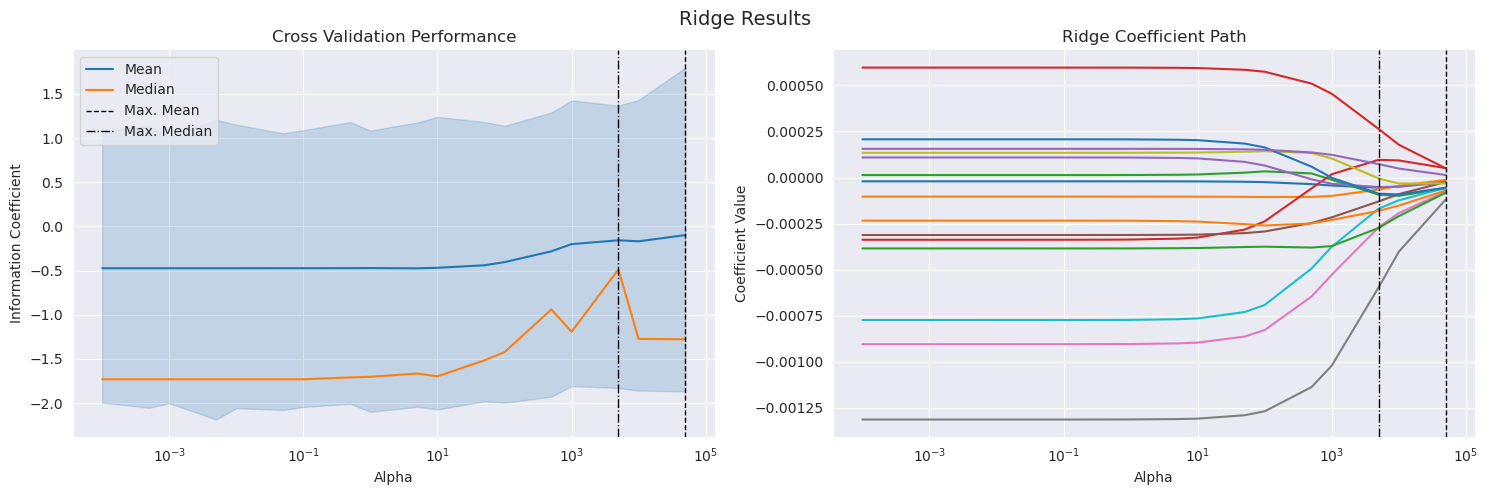

In [36]:
fig, axes = plt.subplots(ncols=2, sharex=True, figsize=(15, 5))

scores_by_alpha = ridge_scores.groupby('alpha').ic.agg(['mean', 'median'])
best_alpha_mean = scores_by_alpha['mean'].idxmax()
best_alpha_median = scores_by_alpha['median'].idxmax()

ax = sns.lineplot(x='alpha',
                  y='ic',
                  data=ridge_scores,
                  estimator=np.mean,
                  label='Mean',
                  ax=axes[0])

scores_by_alpha['median'].plot(logx=True,
                               ax=axes[0],
                               label='Median')

axes[0].axvline(best_alpha_mean,
                ls='--',
                c='k',
                lw=1,
                label='Max. Mean')
axes[0].axvline(best_alpha_median,
                ls='-.',
                c='k',
                lw=1,
                label='Max. Median')
axes[0].legend()
axes[0].set_xscale('log')
axes[0].set_xlabel('Alpha')
axes[0].set_ylabel('Information Coefficient')
axes[0].set_title('Cross Validation Performance')

ridge_coeffs.plot(logx=True,
                  legend=False,
                  ax=axes[1],
                  title='Ridge Coefficient Path')

axes[1].axvline(best_alpha_mean,
                ls='--',
                c='k',
                lw=1,
                label='Max. Mean')
axes[1].axvline(best_alpha_median,
                ls='-.',
                c='k',
                lw=1,
                label='Max. Median')
axes[1].set_xlabel('Alpha')
axes[1].set_ylabel('Coefficient Value')

fig.suptitle('Ridge Results', fontsize=14)
sns.despine()
fig.tight_layout()
fig.subplots_adjust(top=.9)

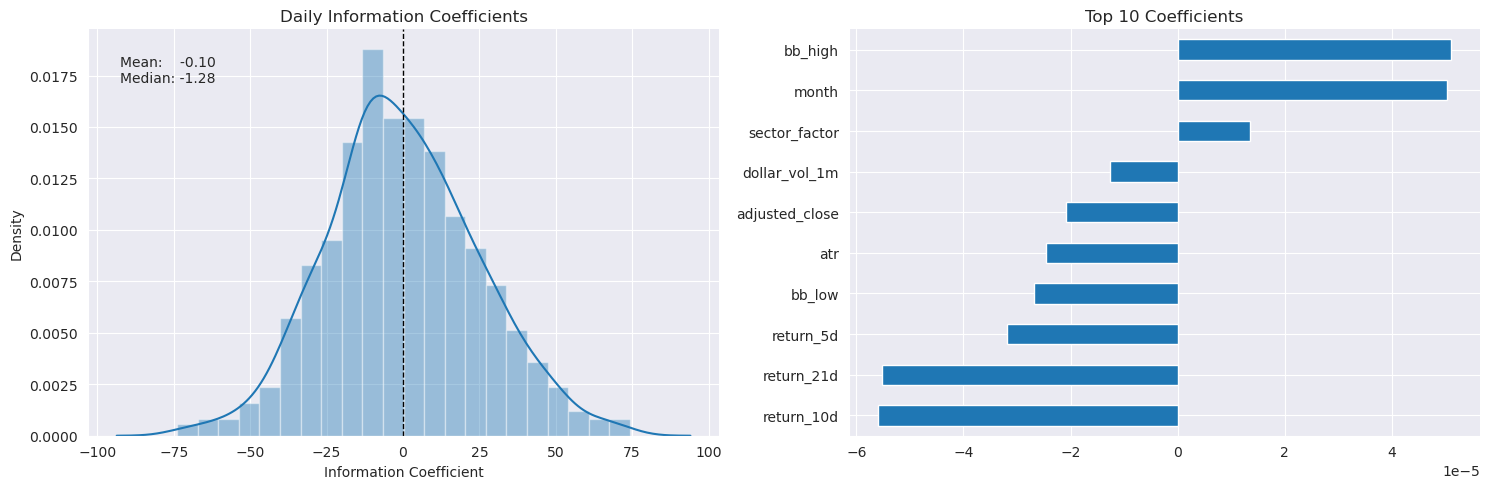

In [37]:
best_alpha = ridge_scores.groupby('alpha').ic.mean().idxmax()
fig, axes = plt.subplots(ncols=2, figsize=(15, 5))
plot_ic_distribution(ridge_scores[ridge_scores.alpha == best_alpha],
                     ax=axes[0])
axes[0].set_title('Daily Information Coefficients')
top_coeffs = ridge_coeffs.loc[best_alpha].abs().sort_values().head(10).index
top_coeffs.tolist()
ridge_coeffs.loc[best_alpha, top_coeffs].sort_values().plot.barh(ax=axes[1],
                                                                 title='Top 10 Coefficients')
sns.despine()
fig.tight_layout()

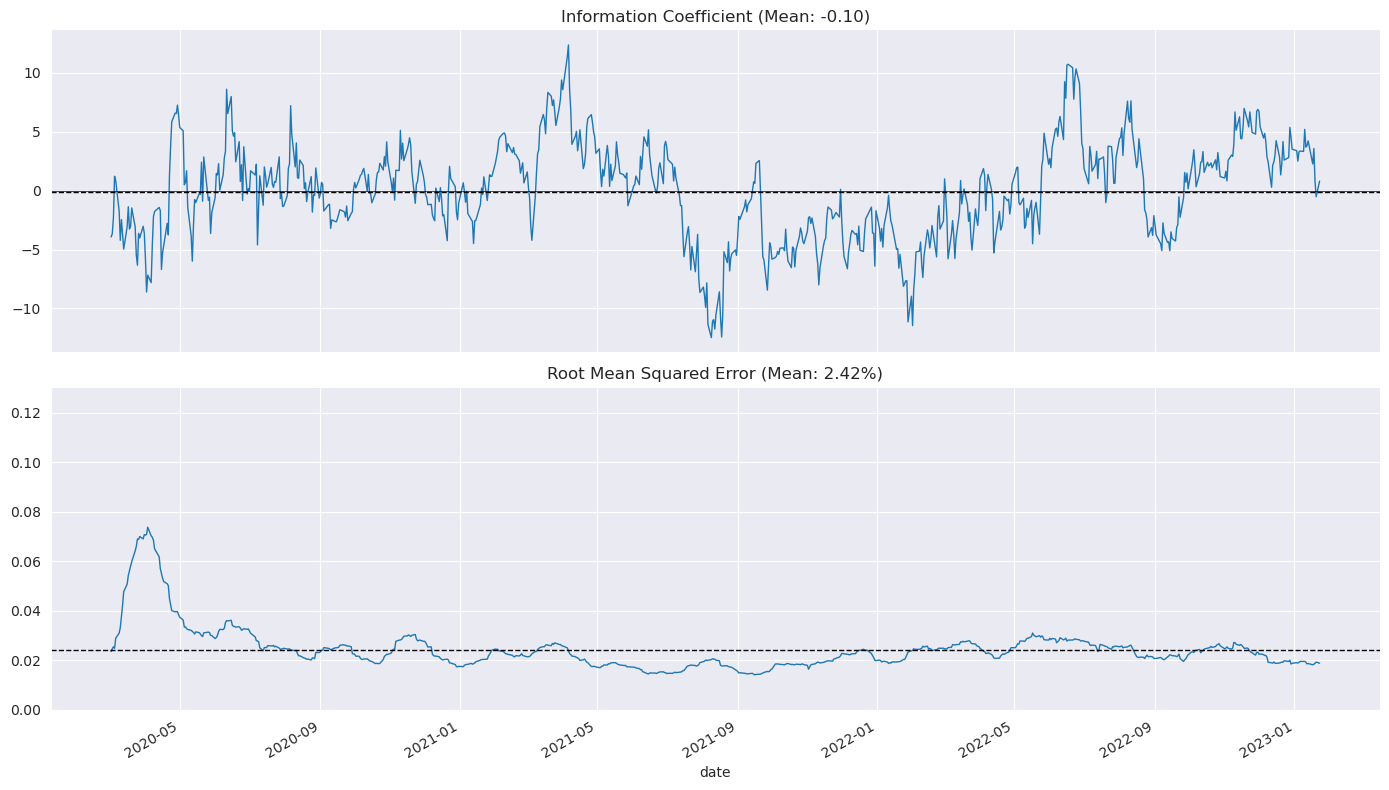

In [38]:
plot_rolling_ic(ridge_scores[ridge_scores.alpha==best_alpha])

## Lasso CV

### Define cross-validation parameters

In [53]:
lasso_alphas = np.logspace(-10, -3, 8)

In [54]:
train_period_length = 63
test_period_length = 10
YEAR = 252
n_splits = int(3 * YEAR / test_period_length) # three years
lookahead = 1

In [55]:
cv = MultipleTimeSeriesCV(n_splits=n_splits,
                          test_period_length=test_period_length,
                          lookahead=lookahead,
                          train_period_length=train_period_length)

### Run cross-validation with Lasso regression

In [56]:
target = f'target_{lookahead}d'

scaler = StandardScaler()
X = X.drop([c for c in X.columns if 'year' in c], axis=1)

In [57]:
%%time

lasso_coeffs, lasso_scores, lasso_predictions = {}, [], []
for alpha in lasso_alphas:
    print(alpha, end=' ', flush=True)
    model = Lasso(alpha=alpha,
                  fit_intercept=False,  # StandardScaler centers data
                  random_state=42,
                  tol=1e-3,
                  max_iter=1000,
                  warm_start=True,
                  selection='random')

    pipe = Pipeline([
        ('scaler', StandardScaler()),
        ('model', model)])
    coeffs = []
    for i, (train_idx, test_idx) in enumerate(cv.split(X), 1):
        t = time()
        X_train, y_train, = X.iloc[train_idx], y[target].iloc[train_idx]
        X_test, y_test = X.iloc[test_idx], y[target].iloc[test_idx]

        pipe.fit(X=X_train, y=y_train)
        y_pred = pipe.predict(X_test)

        preds = y_test.to_frame('actuals').assign(predicted=y_pred)
        preds_by_day = preds.groupby(level='date')
        scores = pd.concat([preds_by_day.apply(lambda x: spearmanr(x.predicted,
                                                                   x.actuals)[0] * 100)
                            .to_frame('ic'),
                            preds_by_day.apply(lambda x: np.sqrt(mean_squared_error(y_pred=x.predicted,
                                                                                    y_true=x.actuals)))
                            .to_frame('rmse')],
                           axis=1)

        lasso_scores.append(scores.assign(alpha=alpha))
        lasso_predictions.append(preds.assign(alpha=alpha))

        coeffs.append(pipe.named_steps['model'].coef_)

    lasso_coeffs[alpha] = np.mean(coeffs, axis=0)

1e-10 1e-09 1e-08 1e-07 1e-06 1e-05 0.0001 0.001 CPU times: user 3min 1s, sys: 5.18 s, total: 3min 6s
Wall time: 31.3 s


### Store Results

In [58]:
lasso_scores = pd.concat(lasso_scores)
lasso_scores.to_hdf('data.h5', 'lasso/scores')

lasso_coeffs = pd.DataFrame(lasso_coeffs, index=X.columns).T
lasso_coeffs.to_hdf('data.h5', 'lasso/coeffs')

lasso_predictions = pd.concat(lasso_predictions)
lasso_predictions.to_hdf('data.h5', 'lasso/predictions')

### Evaluate Lasso Results

In [59]:
best_alpha = lasso_scores.groupby('alpha').ic.mean().idxmax()
preds = lasso_predictions[lasso_predictions.alpha==best_alpha]

lasso_r, lasso_p = spearmanr(preds.actuals, preds.predicted)
print(f'Information Coefficient (overall): {lasso_r:.3%} (p-value: {lasso_p:.4%})')

Information Coefficient (overall): -0.096% (p-value: 79.2977%)


In [60]:
lasso_scores.groupby('alpha').ic.agg(['mean', 'median'])

,mean,median
alpha,,
1.000000e-10,-0.473827,-1.731602
1.000000e-09,-0.473867,-1.731602
1.000000e-08,-0.473811,-1.731602
1.000000e-07,-0.473261,-1.732839
1.000000e-06,-0.470194,-1.683364
1.000000e-05,-0.431475,-1.644403
1.000000e-04,-0.257150,-0.661101
1.000000e-03,1.085798,0.761905


### Lasso Coefficient Path

ValueError: cannot reindex on an axis with duplicate labels

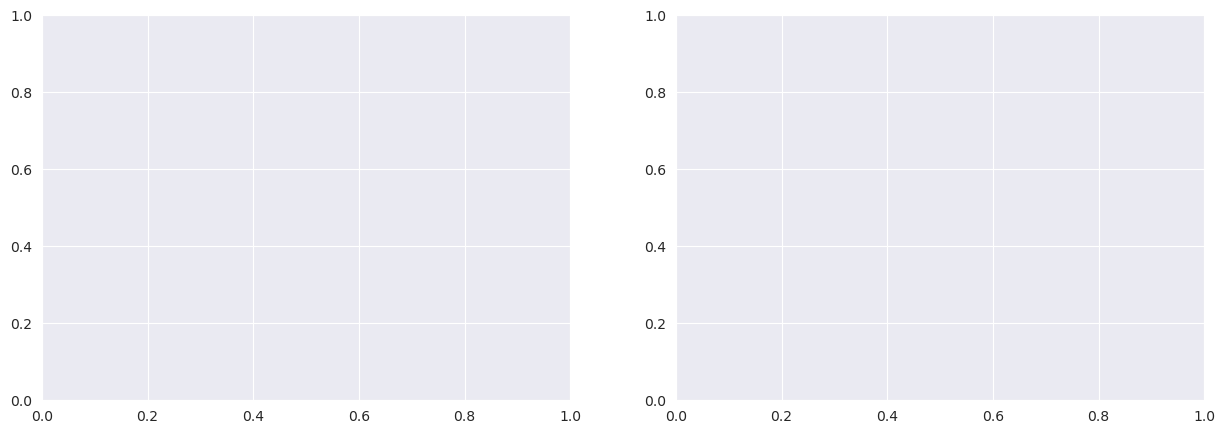

In [61]:
fig, axes = plt.subplots(ncols=2, sharex=True, figsize=(15, 5))

#lasso_scores = lasso_scores.drop_duplicates(subset='alpha')
scores_by_alpha = lasso_scores.groupby('alpha').ic.agg(['mean', 'median'])
best_alpha_mean = scores_by_alpha['mean'].idxmax()
best_alpha_median = scores_by_alpha['median'].idxmax()

ax = sns.lineplot(x='alpha', y='ic', data=lasso_scores, estimator=np.mean, label='Mean', ax=axes[0])

scores_by_alpha['median'].plot(logx=True, ax=axes[0], label='Median')

axes[0].axvline(best_alpha_mean, ls='--', c='k', lw=1, label='Max. Mean')
axes[0].axvline(best_alpha_median, ls='-.', c='k', lw=1, label='Max. Median')
axes[0].legend()
axes[0].set_xscale('log')
axes[0].set_xlabel('Alpha')
axes[0].set_ylabel('Information Coefficient')
axes[0].set_title('Cross Validation Performance')

lasso_coeffs.plot(logx=True, legend=False, ax=axes[1], title='Lasso Coefficient Path')
axes[1].axvline(best_alpha_mean, ls='--', c='k', lw=1, label='Max. Mean')
axes[1].axvline(best_alpha_median, ls='-.', c='k', lw=1, label='Max. Median')
axes[1].set_xlabel('Alpha')
axes[1].set_ylabel('Coefficient Value')

fig.suptitle('Lasso Results', fontsize=14)
fig.tight_layout()
fig.subplots_adjust(top=.9)
sns.despine()

### Lasso IC Distribution and Top 10 Features

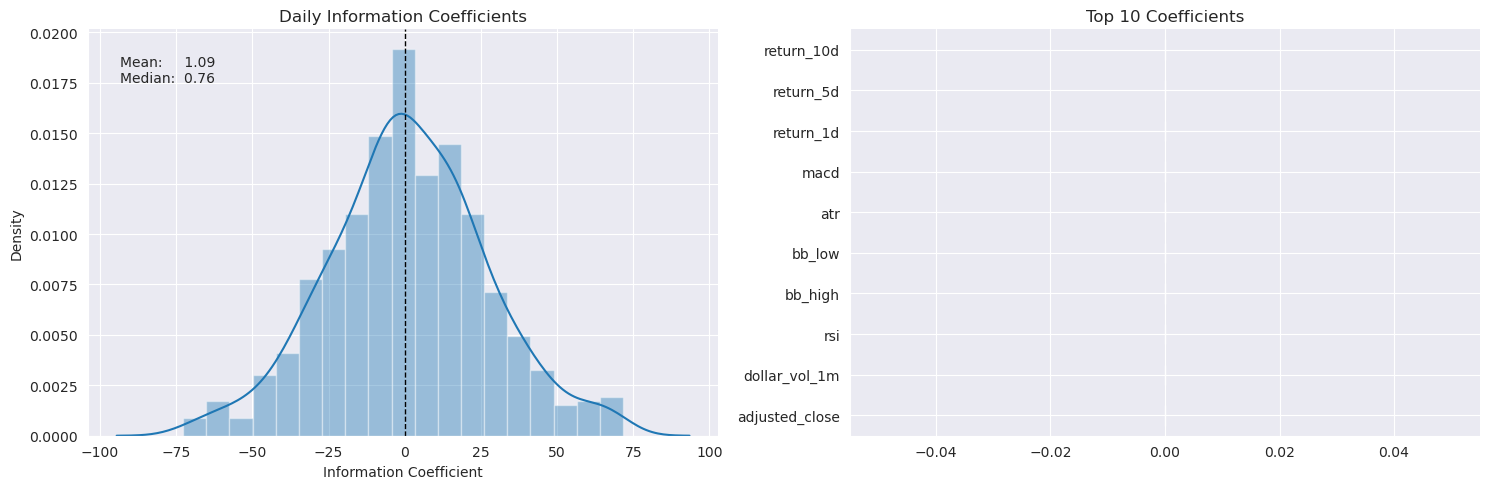

In [62]:
best_alpha = lasso_scores.groupby('alpha').ic.mean().idxmax()

fig, axes = plt.subplots(ncols=2, figsize=(15, 5))
plot_ic_distribution(lasso_scores[lasso_scores.alpha==best_alpha], ax=axes[0])
axes[0].set_title('Daily Information Coefficients')

top_coeffs = lasso_coeffs.loc[best_alpha].abs().sort_values().head(10).index
top_coeffs.tolist()
lasso_coeffs.loc[best_alpha, top_coeffs].sort_values().plot.barh(ax=axes[1], title='Top 10 Coefficients')

sns.despine()
fig.tight_layout();

## Compare results

In [63]:
best_ridge_alpha = ridge_scores.groupby('alpha').ic.mean().idxmax()
best_ridge_preds = ridge_predictions[ridge_predictions.alpha==best_ridge_alpha]
best_ridge_scores = ridge_scores[ridge_scores.alpha==best_ridge_alpha]

In [64]:
best_lasso_alpha = lasso_scores.groupby('alpha').ic.mean().idxmax()
best_lasso_preds = lasso_predictions[lasso_predictions.alpha==best_lasso_alpha]
best_lasso_scores = lasso_scores[lasso_scores.alpha==best_lasso_alpha]

In [65]:
df = pd.concat([lr_scores.assign(Model='Linear Regression'),
               best_ridge_scores.assign(Model='Ridge Regression'),
               best_lasso_scores.assign(Model='Lasso Regression')]).drop('alpha', axis=1)
df.columns = ['IC', 'RMSE', 'Model']

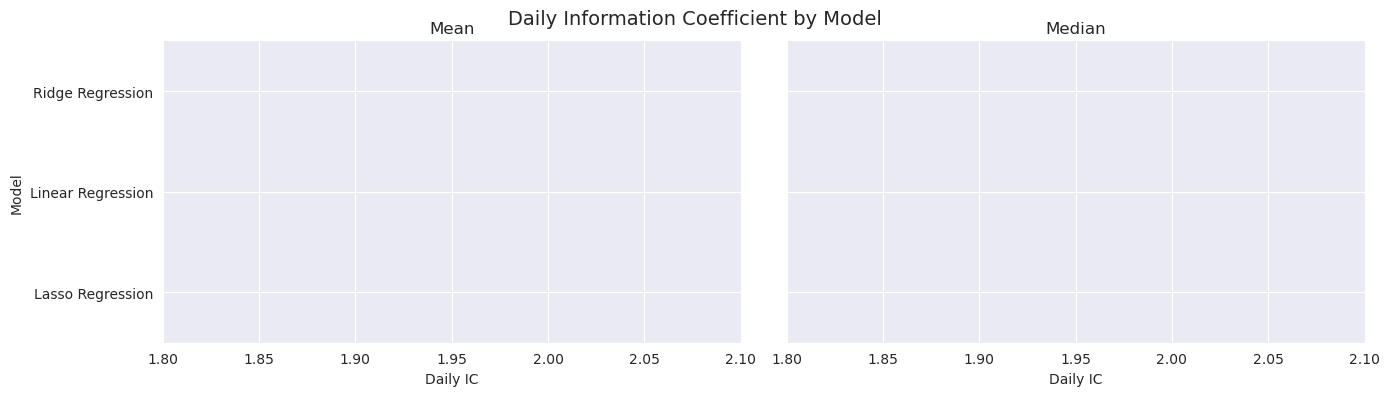

In [66]:
scores = df.groupby('Model').IC.agg(['mean', 'median'])
fig, axes = plt.subplots(ncols=2, figsize=(14,4), sharey=True, sharex=True)

scores['mean'].plot.barh(ax=axes[0], xlim=(1.85, 2), title='Mean')
scores['median'].plot.barh(ax=axes[1], xlim=(1.8, 2.1), title='Median')
axes[0].set_xlabel('Daily IC')
axes[1].set_xlabel('Daily IC')

fig.suptitle('Daily Information Coefficient by Model', fontsize=14)
sns.despine()
fig.tight_layout()
fig.subplots_adjust(top=.9)